# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta'))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}\sum_{i\in\bf{\theta}_0}\log g(x_i)+\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})+\sum_{i\in\bf{\theta}}(f(x_{T,i},\theta')/(1-f(x_{T,i},\theta')))\log (1-g(x_{D,i}))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from IPython.display import Image, display

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.backend as K
import tensorflow.keras 

In [3]:
tf.__version__

'2.0.0'

# Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

In [4]:
N = 1000000
theta0_param = 0 #this is the simulation ... N.B. this notation is reversed from above!
theta1_param = 1 #this is the data (the target)

theta0 = np.random.normal(theta0_param,1,N)
theta1 = np.random.normal(theta1_param,1,N)
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0,theta1])
yvals = np.concatenate([labels0,labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals, yvals, test_size=0.5)

# Weight Model

Let's show that the reweighting works by training a DCTR model.

In [5]:
theta_min = -2
theta_max = 2

theta_many = np.random.uniform(theta_min,theta_max,N)
vals_many = np.random.normal(theta_many,1,N)
simulation = list(zip(vals_many,theta_many))

vals_target = np.random.normal(theta1_param,1,N)
data = list(zip(vals_target,theta_many))

In [6]:
model_weight = Sequential()
model_weight.add(Dense(20, input_dim=2, activation='relu'))
model_weight.add(Dense(40, activation='relu'))
model_weight.add(Dense(1, activation='sigmoid'))

In [7]:
data_labels = np.ones(len(data))
simulation_labels = np.zeros(len(simulation))
X = np.concatenate((data, simulation))
Y = np.concatenate((data_labels, simulation_labels))
X_train_weight, X_test_weight, Y_train_weight, Y_test_weight = train_test_split(X, Y, test_size=0.5)

In [8]:
model_weight.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
model_weight.fit(X_train_weight, Y_train_weight, epochs=3, batch_size=5000)

Train on 1000000 samples
Epoch 1/3
1000000/1000000 [==============================] - 4s 4us/sample - loss: 0.5462 - accuracy: 0.6940
Epoch 2/3
1000000/1000000 [==============================] - 2s 2us/sample - loss: 0.5130 - accuracy: 0.7107
Epoch 3/3
1000000/1000000 [==============================] - 2s 2us/sample - loss: 0.5111 - accuracy: 0.7125


In [10]:
exact_weights = np.exp(-0.5*(theta0-theta1_param)**2+0.5*(theta0-theta0_param)**2)

In [11]:
pred_input = np.array(list(zip(theta0,theta0_param*np.ones(len(theta0)))))
preds = model_weight.predict(pred_input)

In [12]:
pred_weights = preds/(1.-preds)

In [13]:
pred_input.shape

(1000000, 2)

In [14]:
theta0.shape

(1000000,)

In [15]:
input_pred = np.array(list(zip(np.array([0]),np.array([1]))))
print(input_pred.shape)
model_weight.predict(input_pred)

(1, 2)


array([[0.52883583]], dtype=float32)

In [16]:
print(pred_input)

[[ 0.68643198  0.        ]
 [-0.85650089  0.        ]
 [-1.0674002   0.        ]
 ...
 [ 1.00700804  0.        ]
 [ 0.51133945  0.        ]
 [-2.0419641   0.        ]]


In [17]:
preds

array([[0.53728664],
       [0.2022613 ],
       [0.17626628],
       ...,
       [0.62273026],
       [0.488773  ],
       [0.08970556]], dtype=float32)

In [18]:
pred_weights

array([[1.1611651 ],
       [0.25354332],
       [0.21398455],
       ...,
       [1.6506233 ],
       [0.9560782 ],
       [0.09854566]], dtype=float32)

In [19]:
exact_weights

array([1.20494266, 0.25756043, 0.20858676, ..., 1.66031616, 1.01140398,
       0.07871165])

In [20]:
plt.cla()
bins = np.linspace(0,10,51)
plt.hist(np.clip(exact_weights, bins[0], bins[-1]), bins=bins, alpha=0.5, label='Exact')
plt.hist(np.clip(pred_weights, bins[0], bins[-1]), bins=bins, alpha=0.5, label='Predicted')
plt.title("Compare exact and Predicted Weights")
plt.legend(loc=1)
plt.xlabel("Weight")
plt.savefig("Weight_dist.png")

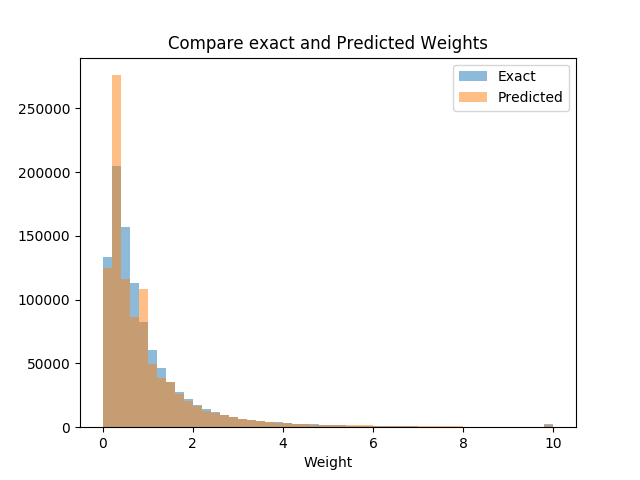

In [21]:
display(Image(filename="Weight_dist.png"))

Now, for the fitting part, let's factorize the problem and assume we already have a good DCTR model.  In this Gaussian case, we know the right answer so we can just use the exact reweighting instead of the NN one.

# Fitting Model

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

In [148]:
thetas = np.linspace(0,2,10)
train_result_list = []
for i in range(len(thetas)):
    weight_value = model_weight.predict(np.array(list(zip(X_train,thetas[i]*np.ones(len(X_train))))))
    weight = weight_value/(1-weight_value)
    weight = tf.convert_to_tensor(weight.astype(np.float32))
    train_result_list.append(weight)

### Using trained model rather than exact Gaussian weights

In [149]:
myinputs = Input(shape=(1,))

x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
#model.summary()

def my_loss_wrapper(weight,val=0.0):
            
    theta0 = val #target value 
    def my_loss(y_true,y_pred):
        t_loss = y_true*(y_true - y_pred)**2+(weight**2)*(1.-y_true)*(y_true - y_pred)**2
        return K.mean(t_loss)
    return my_loss

In [159]:
lvals = []
for i in range(len(thetas)):
    theta = thetas[i]
    model.compile(optimizer='adam', loss=my_loss_wrapper(train_result_list[i],theta),metrics=['accuracy'])
    model.fit(np.array(X_train), y_train, epochs=1, batch_size=len(X_train),validation_data=(np.array(X_test), y_test),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
print(lvals) 

Train on 1000000 samples, validate on 1000000 samples
1000000/1000000 [==============================] - 25s 25us/sample - loss: 0.3996 - accuracy: 0.5160 - val_loss: 0.4002 - val_accuracy: 0.5296
Train on 1000000 samples, validate on 1000000 samples
1000000/1000000 [==============================] - 25s 25us/sample - loss: 0.3536 - accuracy: 0.5295 - val_loss: 0.3450 - val_accuracy: 0.5461
Train on 1000000 samples, validate on 1000000 samples
1000000/1000000 [==============================] - 19s 19us/sample - loss: 0.3245 - accuracy: 0.5458 - val_loss: 0.3125 - val_accuracy: 0.5635
Train on 1000000 samples, validate on 1000000 samples
1000000/1000000 [==============================] - 14s 14us/sample - loss: 0.3042 - accuracy: 0.5637 - val_loss: 0.2917 - val_accuracy: 0.5811
Train on 1000000 samples, validate on 1000000 samples
1000000/1000000 [==============================] - 13s 13us/sample - loss: 0.2907 - accuracy: 0.5814 - val_loss: 0.2793 - val_accuracy: 0.5975
Train on 100000

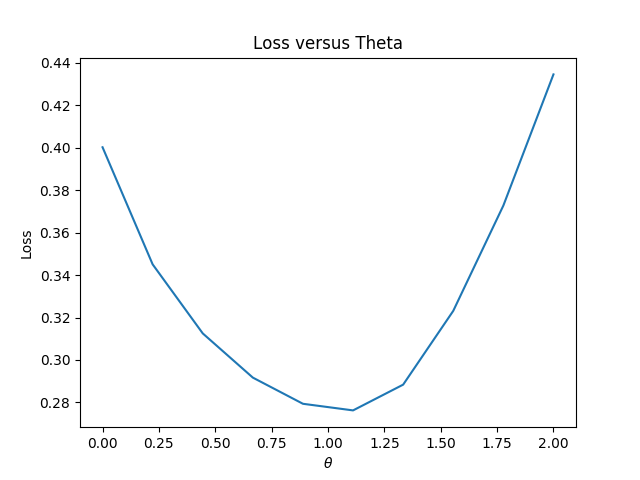

In [160]:
plt.cla()
loss_finish = [loss_value[-1] for loss_value in lvals]
plt.plot(thetas,loss_finish)
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.title("Loss versus Theta")
plt.savefig("Theta.png")
display(Image(filename="Theta.png"))